## Imports

In [9]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import tensorflow as tf
import random
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import traceback
import logging
#!pip install opendatasets
#import opendatasets as od

In [ ]:
## Get first datasets of x: tweets, y: sentiments
!wget https://huggingface.co/datasets/zeroshot/twitter-financial-news-sentiment/raw/main/sent_train.csv
!wget https://huggingface.co/datasets/financial_phrasebank/resolve/main/data/FinancialPhraseBank-v1.0.zip

# New, unknown datapoints - used as test dataset at the very end
!wget https://huggingface.co/datasets/zeroshot/twitter-financial-news-sentiment/raw/main/sent_valid.csv

In [ ]:
# Run if zip file is present, and csv of corresponding dataset is not to be found:
# stock_data.csv

# Link: https://www.kaggle.com/datasets/yash612/stockmarket-sentiment-dataset/data
!unzip stock-market-sentiment.zip

In [ ]:
# Run if zip file is present, and csv of corresponding dataset is not to be found:
# stock_tweet_sentiment.csv

# Link: https://www.kaggle.com/datasets/chenxidong/stock-tweet-sentiment-dataset
!unzip stock-tweet-sentiment-dataset.zip

## Data Pre-Processing: Cleaning Tweet Strings

In [10]:
## Text cleaning script
import re,csv,nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

#stemmer  = PorterStemmer()
lemm = WordNetLemmatizer()

def lem_sentence(sentence):
    complete=''
    tokens =nltk.wordpunct_tokenize(sentence)
    for token in tokens:
        complete += lemm.lemmatize(token) + ' '
    return complete


def replace_text(nstr):
    """
    Parameters
    ----------
    nstr : str
        A string row (eg. from a CSV file), while iterating,
        sent in for filtering/cleaning based on the below reg-ex.

    Returns
    ----------
    nstr : str
        Cleaned string.
    """
    # Links
    nstr = re.sub('http(?:[\d\w]|[^\s\d\w])+','user',nstr)
    # Users
    nstr = re.sub('\@[\w\d]+','user',nstr)

    # 's 'd
    nstr = re.sub('\'[sd]','',nstr)

    #s
    nstr = re.sub('(\w{2,})s[\b$]',r'\1',nstr)

    #lemma
    #nstr = lem_sentence(nstr)

    # Stock codes
    #nstr = re.sub('(?:(?: |\t|^)(?:(?:[A-HJ-Z]{1})|(?:[A-Z]{2,})))+(?:$| |\t)',' stck ',nstr)
    nstr = re.sub('(?:(?: |\t|^)\$?(?:(?:[A-HJ-Z]{1})|(?:[A-Z]{2,})))+(?:$| |\t)',' stck ',nstr)

    #NUMBERS
    nstr = re.sub('\d+[\,\.\-]*\d*',' NMBR ',nstr)

    #Any symbols
    nstr = re.sub('[^\s\d\w]',' ',nstr)

    #Spaces
    nstr = re.sub('[ \t]+',' ',nstr)

    #Repeat N
    nstr = re.sub('(?:NMBR\s)+','NMBR ',nstr)

    #Spaces
    nstr = re.sub('[ \t]+',' ',nstr)

    #to lower case
    nstr = nstr.lower()

    return nstr

def clean(input_file: str, destination: str, w_lbl_col="label", w_txt_col="text", r_lbl_col="label", r_txt_col="text", encoding='utf-8'):
    """
    Parameters
    ----------
    input_file : str
        Path of the CSV file that has uncleaned tweets, with
        eg. links, uppercase letters, unknown characters etc.

    destination : str
        Cleaned string tweets (based on defined reg-ex crit
        above), written to a new CSV file.
    """
    f=open(input_file, encoding=encoding, newline='')

    processed_file = open(destination, mode="+w",encoding=encoding,newline='')

    reader = csv.DictReader(f)
    writer = csv.DictWriter(processed_file, fieldnames=[w_txt_col, w_lbl_col])

    r = {w_txt_col: w_txt_col, w_lbl_col: w_lbl_col}
    writer.writerow(r)

    for row in reader:
        clean = replace_text(row[r_txt_col])

        r = {w_txt_col: clean, w_lbl_col: row[r_lbl_col]}
        writer.writerow(r)

In [335]:
try:
    ## DATA MUST BE CLEANED FIRST
    ## In one of the datasets, 1 means positive, and 2 means neutral. Here, their meanings are being swapped
    ## to ensure consistency.

    # Dataset of zeroshot/twitter-financial-news-sentiment
    clean('sent_train.csv', 'clean_train.csv')
    df1 = pd.read_csv('clean_train.csv', sep=',')#.replace({1:2, 2:1})

    # Dataset of financial_phrasebank
    df2 = pd.read_csv('FinancialPhraseBank-v1.0/Sentences_AllAgree.txt', sep='@', encoding='latin-1')
    df2.columns = ['text','label']
    df2.to_csv('unclean_2.csv', index=None)
    clean('unclean_2.csv', 'clean_2.csv')
    df2 = pd.read_csv('clean_2.csv', encoding='latin-1')

    # New dataset with majorly negative and positive labelled data, instead of too many ambiguous neutral ones
    clean('stock_data.csv', 'clean_new_dataset.csv', r_txt_col='Text', r_lbl_col='Sentiment')
    df3 = pd.read_csv('clean_new_dataset.csv')
    df3 = df3.loc[(df3['label'] == -1) | (df3['label'] == 1)].replace({-1:0})

    # Another dataset, but here, negative sentiment tweets are filtered out, for specially training the model
    # with negative sentiment identification
    clean('stock_tweet_sentiment.csv', 'clean_sentiment.csv', r_txt_col='text', r_lbl_col='Sentiment')
    df4 = pd.read_csv('clean_sentiment.csv')
    df4 = df4.loc[df4['label'] == -1].replace({-1:0})
except FileNotFoundError:
    logging.error(traceback.format_exc())

In [336]:
df1.columns
print(df1.shape) # 9543,2
df1.head()

df2.columns
print(df2.shape) # 2263,2
df2.head()

df3.columns
print(df3.shape) # 3452,2
df3.head()

print(df4.shape)

(9543, 2)
(2263, 2)
(5791, 2)
(2598, 2)


In [337]:
## Join all dfs together to form a collective dataset (roughly total of 17700 datapoints)
df = pd.concat([df1, df2, df3, df4]) #,df3, df4, df4_only_neutral[:6000]])

## Casting type of the text to string instead of 'object'
df['text'] = df['text'].astype("string")
df = df.replace({'negative': 0, 'positive': 1, 'neutral': 2})
print(df.dtypes)

print("\nNumber of negatives: ", len(df.loc[(df['label'] == 0)]))
print("Number of positives: ", len(df.loc[(df['label'] == 1)]))
print("Number of neutrals: ", len(df.loc[(df['label'] == 2)]))

df.shape

text     string
label     int64
dtype: object

Number of negatives:  6449
Number of positives:  6178
Number of neutrals:  7568


(20195, 2)

## Training (split)
<img src='https://i.imgur.com/pkL9mHS.png' alt='train-test-split'>

In [338]:
## Data Split:
from sklearn.model_selection import train_test_split
#from imblearn.over_sampling import RandomOverSampler

# Randomizing also added
X_train, X_val, y_train, y_val = train_test_split(np.array(df['text']), np.array(df['label']), test_size=0.30, random_state=42)

#resamp = RandomOverSampler(random_state=42, sampling_strategy='not majority')
#X_train = X_train.reshape(-1, 1)
#bal_X_train, bal_y_train = resamp.fit_resample(X_train, y_train)

print(X_train.shape)
#print(bal_X_train.shape, bal_y_train.shape)

(14136,)


## Tokenizing the strings to be passed in for training

In [339]:
## Optional: See how the tokenized strings look like (if curious)
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(df['text'])
word_index = tokenizer.word_index

word_sequences = tokenizer.texts_to_sequences(df['text'])
padded = pad_sequences(word_sequences, padding='post')
print(word_index, padded.shape)
print()
print(padded[0])

{'<OOV>': 1, 'stck': 2, 'nmbr': 3, 'user': 4, 'the': 5, 'to': 6, 'of': 7, 'in': 8, 'a': 9, 'and': 10, 'for': 11, 'on': 12, 'is': 13, 'at': 14, 'stock': 15, 'as': 16, 's': 17, 'from': 18, 'by': 19, 'it': 20, 'with': 21, 'up': 22, 'this': 23, 'will': 24, 'be': 25, 'are': 26, 'i': 27, 'has': 28, 'its': 29, 'after': 30, 'that': 31, 'new': 32, 'market': 33, 'more': 34, 'year': 35, 'here': 36, 'q': 37, 'u': 38, 'over': 39, 'earnings': 40, 'today': 41, 'm': 42, 'price': 43, 'million': 44, 'you': 45, 'company': 46, 'buy': 47, 'day': 48, 'have': 49, 'short': 50, 't': 51, 'stocks': 52, 'out': 53, 'down': 54, 'but': 55, 'trade': 56, 'mn': 57, 'not': 58, 'group': 59, 'marketscreener': 60, 'sales': 61, 'inc': 62, 'about': 63, 'was': 64, 'profit': 65, 'an': 66, 'now': 67, 'shares': 68, 'results': 69, 'says': 70, 'target': 71, 'or': 72, 'what': 73, 'we': 74, 'long': 75, 'coronavirus': 76, 'volume': 77, 'week': 78, 'china': 79, 'economy': 80, 'if': 81, 'some': 82, 'options': 83, 'cut': 84, 'net': 85, 

In [340]:
## Make a Encoding layer that is PART OF the model
Encoder = tf.keras.layers.TextVectorization()
Encoder.adapt(X_train)
print(len(Encoder.get_vocabulary()))

16778


## **Training the model**

### Pre-Processing (run the raw tweet through cleaner + tokenizer)

In [ ]:
# Optional: Make a tokenizer (not continued anymore)
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, padding='post')
print(len(word_index), train_padded.shape, train_padded[0])

test_sequences = tokenizer.texts_to_sequences(X_val)
test_padded = pad_sequences(test_sequences, padding='post')
print(len(word_index), test_padded.shape)

In [ ]:
#callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.01)
#new_train_sequences = tf.keras.layers.UpSampling2D(size=(2,1))(train_sequences)
#new_train_padded = pad_sequences(new_train_sequences, padding='post')

In [487]:
## Initializing the model
sentiment_model = tf.keras.Sequential([
      Encoder,
      tf.keras.layers.Embedding(
          input_dim=len(Encoder.get_vocabulary()),
          output_dim=16,
          mask_zero=True),
      tf.keras.layers.AveragePooling1D(),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24)),
      #tf.keras.layers.Dense(36, activation='softmax'),
      tf.keras.layers.Dense(10, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
      tf.keras.layers.Dense(3, activation='softmax', name='Output')
])

Epoch 1/13


272/272 [==============================] - 14s 40ms/step - loss: 1.1801 - accuracy: 0.3765 - val_loss: 1.1251 - val_accuracy: 0.3760
Epoch 2/13
272/272 [==============================] - 10s 36ms/step - loss: 0.9961 - accuracy: 0.6258 - val_loss: 0.9145 - val_accuracy: 0.7013
Epoch 3/13
272/272 [==============================] - 10s 36ms/step - loss: 0.8008 - accuracy: 0.7802 - val_loss: 0.8357 - val_accuracy: 0.7161
Epoch 4/13
272/272 [==============================] - 9s 33ms/step - loss: 0.6818 - accuracy: 0.8273 - val_loss: 0.7874 - val_accuracy: 0.7305
Epoch 5/13
272/272 [==============================] - 9s 34ms/step - loss: 0.6084 - accuracy: 0.8485 - val_loss: 0.7697 - val_accuracy: 0.7333
Epoch 6/13
272/272 [==============================] - 10s 38ms/step - loss: 0.5453 - accuracy: 0.8703 - val_loss: 0.7658 - val_accuracy: 0.7323
Epoch 7/13
272/272 [==============================] - 10s 37ms/step - loss: 0.4963 - accuracy: 0.8851 - val_loss: 0.7501 - val_accuracy: 0.7384
Epoch

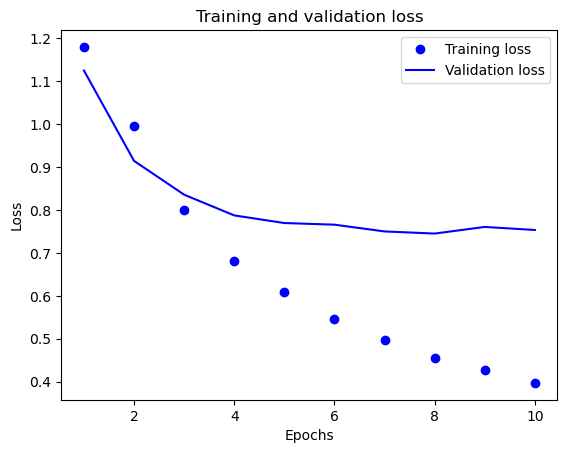

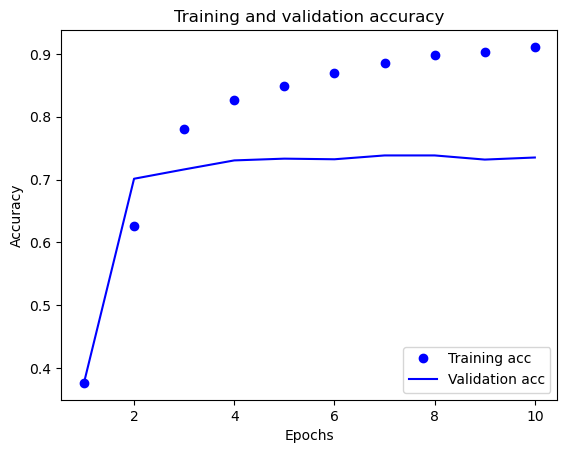

In [488]:
## Compile + Run Model
from keras.utils import to_categorical

sentiment_model.compile(optimizer=tf.keras.optimizers.Adam(0.0004), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

# if loss function = CategoricalCrossentropy
y_train_hot=to_categorical(y_train)
y_val_hot=to_categorical(y_val)

history = sentiment_model.fit(x=X_train, y=y_train_hot, epochs=13, validation_data=(X_val, y_val_hot), batch_size=52, callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, mode='min')]) #callbacks=[callback]

history_curve = history.history

print(sentiment_model.summary())

acc = history_curve['accuracy']
val_acc = history_curve['val_accuracy']
loss = history_curve['loss']
val_loss = history_curve['val_loss']

epochs = range(1, len(acc) + 1)

## First Graph
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
print()

## Second graph
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# OPTIONAL
from tf.keras.wrappers.scikit_learn import KerasClassifier 

sentiment_keras_model = KerasClassifier(model=sentiment_model, optimizer="adam", optimizer__learning_rate=0.001, epochs=50, verbose=0)
scoring = ['accuracy', 'precision', 'recall', 'f1']
#results = cross_val_score(estimator, X, dummy_y, cv=kfold)
results = cross_validate(estimator=keras_clf, X=X_train, y=y_train, scoring=scoring, cv=kfold, return_train_score=True, return_estimator=True)

## Exporting the model

In [485]:
sentiment_model.save("sentiment_model/4/model", save_format='tf')

INFO:tensorflow:Assets written to: sentiment_model/4/model/assets


INFO:tensorflow:Assets written to: sentiment_model/4/model/assets


## Loading the model as a black-box

In [506]:
## Testing on a completely new dataset
clean('sent_valid.csv', 'clean_valid.csv')
df5 = pd.read_csv('clean_valid.csv', sep=',')

i = 3

model = tf.keras.models.load_model(f'sentiment_model/{i}/model')
print(model.summary())

y_hot=to_categorical(df5['label'])

predicted_sentiments = np.argmax(model.predict(df5['text']), axis=1)
print(predicted_sentiments)
print(np.argmax(y_hot, axis=1))

diagnostics = model.evaluate(np.array(df5['text']), y_hot)
diagnostics[1]

Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_10 (Text  (None, None)             0         
 Vectorization)                                                  
                                                                 
 embedding_54 (Embedding)    (None, None, 16)          268448    
                                                                 
 average_pooling1d (AverageP  (None, None, 16)         0         
 ooling1D)                                                       
                                                                 
 bidirectional_49 (Bidirecti  (None, 48)               7872      
 onal)                                                           
                                                                 
 dense_79 (Dense)            (None, 10)                490       
                                                     

0.7596315145492554

In [48]:
from keras.utils import to_categorical
from lime.lime_text import LimeTextExplainer

# Explainable AI
# ---------------------------------------
# By using data most likely a subset of the training data, as an example, showcases how the model came to its decision, and which features influenced its prediction the most
clean('sample_train.csv', 'clean_train.csv')
df5 = pd.read_csv('clean_train.csv', sep=',')

i = 3

model = tf.keras.models.load_model(f'sentiment_model/{i}/model')
print(model.summary())

y_hot=to_categorical(df5['label'], num_classes=3)

sample_idx = 152
predicted_sentiments = np.argmax(model.predict([df5['text'][sample_idx]]), axis=1)
print(predicted_sentiments)
print(np.argmax(y_hot, axis=1))

class_names = ['0', '1', '2']
explainer = LimeTextExplainer(class_names=class_names)
exp = explainer.explain_instance(df5['text'][sample_idx], model.predict, top_labels=True)
exp.save_to_file("sentiment_explanation.html")

diagnostics = model.evaluate(np.array(df5['text']), y_hot)
diagnostics[1]

2023-12-28 00:18:43.752366: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_2_grad_concat_split_2_split_dim' with dtype int32
	 [[{{node gradients_split_2_grad_concat_split_2_split_dim}}]]
2023-12-28 00:18:43.752478: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_grad_concat_split_split_dim' with dtype int32
	 [[{{node gradients_split_grad_concat_split_split_dim}}]]
2023-12-28 00:18:43.752535: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_10 (Text  (None, None)             0         
 Vectorization)                                                  
                                                                 
 embedding_54 (Embedding)    (None, None, 16)          268448    
                                                                 
 average_pooling1d (AverageP  (None, None, 16)         0         
 ooling1D)                                                       
                                                                 
 bidirectional_49 (Bidirecti  (None, 48)               7872      
 onal)                                                           
                                                                 
 dense_79 (Dense)            (None, 10)                490       
                                                     

2023-12-28 00:18:48.924213: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-28 00:18:48.925887: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-28 00:18:48.928202: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 1s 713ms/step
[0]
[1 1 1 ... 1 1 1]
157/157 [==============================] - 1s 8ms/step


2023-12-28 00:18:51.452949: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-28 00:18:51.454803: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-28 00:18:51.456536: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

181/181 [==============================] - 2s 5ms/step - loss: 0.5374 - accuracy: 0.8235


0.823519229888916

## Confusion Matrix + Metrics for Model Quality

              precision    recall  f1-score   support

    negative       0.59      0.63      0.61       347
    positive       0.61      0.60      0.61       475
     neutral       0.85      0.84      0.84      1566

    accuracy                           0.76      2388
   macro avg       0.68      0.69      0.69      2388
weighted avg       0.76      0.76      0.76      2388

1814


<AxesSubplot:>

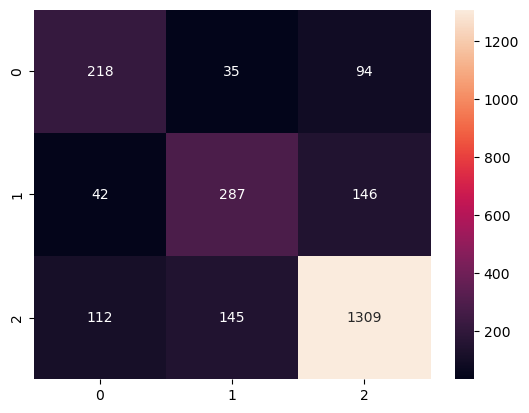

In [507]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
# confusion matrix
mtrx = confusion_matrix(df5['label'], predicted_sentiments)

print(classification_report(df5['label'], predicted_sentiments, target_names=['negative', 'positive', 'neutral']))
print(np.trace(mtrx))
sns.heatmap(mtrx, annot=True, fmt=".0f")